#### 商品特徵欄位
--檔期接續問題
--計算時間問題
##### 目前已可取得：
* 商品ID [business_hour_guid]
* 品牌：將不同品牌使用Label Encoding 加以標示(?)
* 檔次原價 [item_orig_price]
* 檔次促銷價格 [item_price]
* 關鍵字：先挑出根據出現詞頻最高的5~10個行銷用詞(如：熱銷、買_送_...等)，再計算每個商品標題中含有行銷用詞之次數(或將其分等級)[hot_word_times]
* 品類：從order檔案與deal檔案結合	 [code]	
* 促銷與否：結合discount檔案，看其商品是否有加入促銷活動(1 or 0)[is_Discount] 
* 分期：計算該商品是否有提供分期付款優惠 
   [installment_3months] [installment_6months]	[installment_12months] [deny_installment]
* 配送時間：V [shippingdate]
* 上架月份：利用business_hour_order_time_s找出檔次上架之月份(若為累積檔次取其出現頻率最多者) [product_launch_month]	
* 上架星期：利用business_hour_order_time_s找出該天為星期幾(若為累積檔次取其出現頻率最多者) [product_launch_weekday]
* 上架時間：利用business_hour_order_time_s找出上架時間點(以24小時為欄位)  [product_launch_hour]
* 檔期長度(天數)：利用business_hour_order_time_s、business_hour_order_time_e欄位相減	(可先做) [campagin_period]
* 是否為長銷型商品[isLongtern]
* 開賣前三天的銷量:利用order訂單與business_hour_order_time_s時間相減進行計算[sales_3days]
* 是否預購：計算訂購與配送之時間差(若超過三週則設為預購，以1,0劃分) (可先做)[presales]
* 與同類商品的單位價格中位數比較：計算該產品的產品單位價格中位數，與其單位價格比較(使用百分比)[compare_cate_unit_price]
* 可超取：可否超商取貨 [enable_isp]
* 單位價格（單一檔期)[unit_price]
* 總銷售產品單位量 (單一檔期)[quantity_sold_guid]
* 商品平均價格(全檔期)[avg_unit_price]
* 總銷售量(全檔期)[quantity_sold_allguid]

--消費熱衷區間、了解消費者pattern
#### 目標變數：
[ratio_7days]、[ratio_14days]、[ratio_30days]、[ratio_60days]、[ratio_180days]
* 該商品於未來7.14.30.60.180天的預估銷量：利用order訂單與business_hour_order_time_s時間相減進行計算，除以總銷量取得百分比


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re
pd.options.display.max_columns = 100

### 因為deal欄位有名稱遺漏問題，故要將其重新命名，並回存檔案

In [8]:
deal=pd.read_csv("deal2.csv",low_memory=False)

In [11]:
deal=deal.reset_index(drop=False)

In [13]:
deal.columns=['business_hour_guid', 'seller_GUID', 'business_hour_order_time_s',
       'business_hour_order_time_e', 'business_hour_deliver_time_s',
       'business_hour_deliver_time_e', 'pic_alt','zip_code', 'city_name',
       'district_name', 'item_name', 'item_orig_price', 'item_price',
       'item_default_daily_amount', 'event_name', 'event_title',
       'product_spec', 'shopping_cart', 'combo_pack_count',
       'quantity_multiplier', 'city_list', 'deal_acc_business_group_id',
       'acc_business_group_name', 'deal_type', 'is_travel_deal',
       'installment_3months', 'installment_6months', 'installment_12months',
       'deny_installment', 'shippingdate', 'is_long_contract',
       'develope_sales_id', 'operation_sales_id', 'slug', 'ordered_quantity',
       'ordered_total', 'category_list', 'freight_amount', 'enable_isp',
       'discount_price', 'is_wms', 'ancestor_business_hour_guid', 'code_name',
       'code','code_second']

### 與order合併

In [14]:
order_ori =pd.read_csv("order.csv")
order_ori.rename(columns={'(No column name)':'is_returned'}, inplace=True)
order_ori.head()

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type
0,7358E8A1-A918-42CD-A846-AAEF0A0E2B67,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,2.0,1,2010-06-01 18:06:41.987,02C55598-E1E7-40E1-996B-371EAE55F840,1,1111229516,0,NaN
1,A248B260-6366-4A2D-9A29-BF29A170A4AB,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0,2010-06-07 15:34:49.693,02C55598-E1E7-40E1-996B-371EAE55F840,1,1111229574,0,NaN
2,8433DD4F-368D-41EA-9D3B-56E5BAE76BC2,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0,2010-06-07 22:28:37.443,02C55598-E1E7-40E1-996B-371EAE55F840,1,1111193708,0,NaN
3,A85FC574-B5DA-43BE-88C8-326E1B90EE12,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0,2010-06-08 14:38:53.600,02C55598-E1E7-40E1-996B-371EAE55F840,1,1111250894,0,NaN
4,EB9E799B-EB28-4F9F-820F-FF54BBF9E81F,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0,2010-06-09 08:45:17.770,02C55598-E1E7-40E1-996B-371EAE55F840,1,1111386826,0,NaN


In [15]:
df=pd.merge(order_ori,deal,how='left',on=['business_hour_guid','seller_GUID'])

### 將運送開始日期排序，找出有問題的欄位

In [16]:
df.business_hour_deliver_time_e.sort_values(ascending= False).head(5)

3079467    9999-12-31 00:00:00.000
3081700    9999-12-31 00:00:00.000
3474924    9999-05-18 00:00:59.000
3933722    2238-06-27 23:59:00.000
3930316    2238-06-27 23:59:00.000
Name: business_hour_deliver_time_e, dtype: object

* 因為檔次時間有問題的欄位(9999-...)不多，故直接刪除

In [17]:
df=df.drop(index=[3079467,3081700,3474924])

In [18]:
df=df.reset_index(drop=True)
df=df[:4080853]

### 將欄位轉換格式為datetime

In [8]:
import datetime
for i in ['business_hour_order_time_s','create_time','business_hour_order_time_e','business_hour_deliver_time_s','business_hour_deliver_time_e']:
        df[i]=pd.to_datetime(df[i])

### 取出檔期開始之月份 時間點 星期幾 檔次長度 訂購與開始運送之天數差(用來計算是否有預購情況)

In [20]:
df['product_launch_month']=df['business_hour_order_time_s'].apply(lambda x:x.month)
df['product_launch_hour']=df['business_hour_order_time_s'].apply(lambda x:x.hour)
df['product_launch_weekday']=df['business_hour_order_time_s'].apply(lambda x:x.weekday())
df['campagin_period']=(df['business_hour_order_time_e']-df['business_hour_order_time_s']).apply(lambda x:x.days)
df['order_deliver_days']=(df['business_hour_deliver_time_s']-df['business_hour_order_time_s']).apply(lambda x : x.days )
def trans(x):
    if x>=3:
        return 1
    elif x<3:
        return 0
    else:
        return np.NaN

df["presales"]=df['order_deliver_days'].apply(trans)
df['product_launch_year']=df['business_hour_order_time_s'].apply(lambda x:x.year)


##  挑選 2015~2019間的交易紀錄，約有2,113,323筆交易紀錄

In [21]:
df=df[df.product_launch_year>=2015]
df.shape

(2113323, 61)

In [22]:
df.to_csv("df_1519.csv",index=False)

In [3]:
orderdf=pd.read_csv("df_1519.csv")

c:\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
orderdf.sort_values(by='create_time').groupby('business_hour_guid')['subtotal']

In [5]:
guidlist=orderdf.business_hour_guid.unique()

In [14]:
%%time
def checkperiod(a):
    lista=[]
    a['%%']=a['subtotal'].cumsum()/a['subtotal'].sum()
    a['daydiff']=(a['create_time']-a['business_hour_order_time_s']).apply(lambda x:x.days)
    
    q1=a[a['%%']>=0.25]['daydiff'].min()
    q2=a[a['%%']>=0.5]['daydiff'].min()
    q3=a[a['%%']>=0.75]['daydiff'].min()
    lista.append(q1)
    lista.append(q2)
    lista.append(q3)
    return (lista)
dataframe=orderdf[['business_hour_guid','GUID','business_hour_order_time_s','create_time','subtotal']]
totallist=dataframe.groupby('business_hour_guid').apply(checkperiod)

Wall time: 15min 3s


In [19]:
dd=totallist.to_frame().reset_index()
dd.columns=['business_hour_guid','sales_days']

In [31]:
dd=pd.DataFrame(dd.sales_days.values.tolist(), index= dd.business_hour_guid).reset_index()
dd.columns=['business_hour_guid','25%_days','50%_days','75%_days']
dd.head(3)

,business_hour_guid,25%_days,50%_days,75%_days
0,00000793-A001-4C8C-9196-3E6971181246,2,2,2
1,00001911-C3DF-4143-BC25-8AA5FA1A9AF4,3,3,3
2,00001928-AE75-4AA9-8A47-4BDE96D08C2D,8,8,28


In [32]:
dd.to_csv("sales_days",index=False)

In [23]:
df.head(3)

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,code_second,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,presales,product_launch_year
1954791,45B303F5-2997-4A1E-9CED-D510CFF5B0F0,E4D88D44-A734-4A6B-9174-A862244D2D22,三協成事業有限公司,699.0,0,2015-01-01 12:12:44.947,732103DD-F831-4210-8449-6B1917AA37F5,1,1111761039,0,NaN,2015-01-01 12:00:00,2015-01-22 12:00:00,2015-01-01,2015-01-27,Max Tea/印尼/拉茶,249,新北市,八里區,Max Tea-Tarikk印尼拉茶90包方案,1350.0,699.0,20,宅配：只要699元(含運)即可購得【Max Tea】原價1350元Tarikk印尼拉茶90包...,世界公認好喝的奶茶之一！雅加達、峇里島必買伴手禮|口感溫順|好喝就像現泡|還有不可思議的奶泡喔！,NaN,0,1,90.0,[477|492],7,宅配,50,0,0,0,0,0,0.0,0,1112762571,1.112763e+09,43.0,43,30057.0,[],0.0,0,NaN,0,NaN,沖泡/飲品,413.0,50,1,12,3,21,-1,0,2015
1954810,F121067A-41C7-4894-BD82-33A54E589DB7,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,594.0,0,2015-01-01 12:36:05.753,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1,1112303774,0,NaN,2015-01-01 12:00:00,2015-01-14 12:00:00,2015-01-01,2015-01-23,暖暖包袋/生理褲,231,新北市,新店區,蕾絲親膚暖暖包袋生理褲（6件方案）,1794.0,594.0,20,宅配：只要594元(含運)即可帶走原價1794元蕾絲親膚暖暖包袋生理褲6件：神秘黑/自然膚/...,每個女人都要有|獨家設計可放暖暖包生理褲！前後三層防漏超透氣|肚子暖暖減少不適感|安心溫暖月月順。,NaN,1,6,6.0,[477],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,17.0,17,10098.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,13,-1,0,2015
1954814,7CC0DB1C-786E-427E-AD29-C6EC6C860CCF,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,469.0,1,2015-01-01 12:42:11.777,61B117B3-9E4C-4809-9992-0F89E740E5E9,3,1111750722,0,NaN,2015-01-01 12:00:00,2015-01-02 12:00:00,2015-01-01,2015-01-13,外套,231,新北市,新店區,連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款,1800.0,469.0,20,宅配：只要469元(含運)即可帶回原價1800元連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款1...,男女款必備雙面配色外套|防水防風面料|舒適透氣易排汗|修飾身材、鬆緊下擺更合身|給您最時尚S...,NaN,1,1,NaN,[477],7,宅配,22,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,216.0,216,101304.0,[],0.0,0,NaN,0,NaN,流行女裝,1604.0,22,1,12,3,1,-1,0,2015


### 將deal與order合併，並設定交易時間範圍

In [ ]:
df=pd.read_csv("df_1519.csv",low_memory=False)

### 找出商品檔次繼承關係

* 刪除重複檔次ID

In [24]:
tempdf=df[['business_hour_guid','ancestor_business_hour_guid']].drop_duplicates(['business_hour_guid']).reset_index(drop=True)
tempdf.head(3)

,business_hour_guid,ancestor_business_hour_guid
0,732103DD-F831-4210-8449-6B1917AA37F5,NaN
1,E4849B75-FC79-4B2E-AF00-DF82E59B2872,NaN
2,61B117B3-9E4C-4809-9992-0F89E740E5E9,NaN


## 建立查詢table

In [25]:
##將兩欄位位置對調，更名(改名為檔次1,2...)
bhgnoNaN=tempdf[tempdf.ancestor_business_hour_guid.isnull()==False]
dictionary=bhgnoNaN[["ancestor_business_hour_guid","business_hour_guid"]]
dictionary=dictionary.rename(columns={'ancestor_business_hour_guid':'business_hour_guid','business_hour_guid':'business_hour_guid_1'})
dictionary.head(3)

,business_hour_guid,business_hour_guid_1
12,41B9EE4F-601C-4E86-A5D3-4CB811B270BB,22877EDB-28E9-4A26-96B8-D29DA72E42A8
60,30563145-9FFC-49C8-B192-AF5396B63A5C,005BDBB4-1ABA-4A95-BC24-1CE3C75AEB73
70,2CE396EE-35AA-4DCC-A962-087FEC2194F5,07D8C3C7-FB0C-489A-ADFF-085C4F196207


* 先找出檔次ID與前次檔次ID，將已無前檔次ID的檔次作為開頭表格(ancestor_business_hour_guid.isnull()==True)

In [26]:
bhgwithNaN=tempdf[tempdf.ancestor_business_hour_guid.isnull()==True]
bhgwithNaN=bhgwithNaN[['business_hour_guid']]
tmp=pd.merge(bhgwithNaN,dictionary,how="left")
tmp.head(3)

,business_hour_guid,business_hour_guid_1
0,732103DD-F831-4210-8449-6B1917AA37F5,NaN
1,E4849B75-FC79-4B2E-AF00-DF82E59B2872,NaN
2,61B117B3-9E4C-4809-9992-0F89E740E5E9,7EACAF6A-466E-4739-B277-7679DE7B00BA


In [27]:
##沒有前次檔期的商品後面就會顯示NaN,商品最多有17個檔期
i=1
while True:
    dictcol1='business_hour_guid_'+str(i)
    dictcol2='business_hour_guid_'+str(i+1)
    dictionary.columns=[dictcol1,dictcol2]
    tmp=pd.merge(tmp,dictionary,how="left")
    print(tmp[tmp[dictcol2].isnull()==False].shape)
    if(tmp[dictcol2].isnull().all()==True):
        break
    else:
        i=i+1

(723, 3)
(493, 4)
(338, 5)
(231, 6)
(156, 7)
(115, 8)
(91, 9)
(74, 10)
(58, 11)
(33, 12)
(22, 13)
(14, 14)
(10, 15)
(5, 16)
(3, 17)
(0, 18)


In [28]:
tmp['list']=tmp.apply(lambda x: x.tolist(), axis=1)
tmp.head(3)

,business_hour_guid,business_hour_guid_1,business_hour_guid_2,business_hour_guid_3,business_hour_guid_4,business_hour_guid_5,business_hour_guid_6,business_hour_guid_7,business_hour_guid_8,business_hour_guid_9,business_hour_guid_10,business_hour_guid_11,business_hour_guid_12,business_hour_guid_13,business_hour_guid_14,business_hour_guid_15,business_hour_guid_16,business_hour_guid_17,list
0,732103DD-F831-4210-8449-6B1917AA37F5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[732103DD-F831-4210-8449-6B1917AA37F5, nan, na..."
1,E4849B75-FC79-4B2E-AF00-DF82E59B2872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[E4849B75-FC79-4B2E-AF00-DF82E59B2872, nan, na..."
2,61B117B3-9E4C-4809-9992-0F89E740E5E9,7EACAF6A-466E-4739-B277-7679DE7B00BA,ADBC8BB8-E3D8-4564-BCC3-6DA9140E2225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[61B117B3-9E4C-4809-9992-0F89E740E5E9, 7EACAF6..."


### List中 去除空值

In [29]:
def delNaN(x):
    cleanedList = [i for i in x if str(i) != 'nan']
    return cleanedList
tmp['list']=tmp['list'].apply(delNaN)

In [30]:
##找到現在檔次欄位
tmp['present_guid']=tmp['list'].apply(lambda x:x[-1])
tmp.head(3)

,business_hour_guid,business_hour_guid_1,business_hour_guid_2,business_hour_guid_3,business_hour_guid_4,business_hour_guid_5,business_hour_guid_6,business_hour_guid_7,business_hour_guid_8,business_hour_guid_9,business_hour_guid_10,business_hour_guid_11,business_hour_guid_12,business_hour_guid_13,business_hour_guid_14,business_hour_guid_15,business_hour_guid_16,business_hour_guid_17,list,present_guid
0,732103DD-F831-4210-8449-6B1917AA37F5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[732103DD-F831-4210-8449-6B1917AA37F5],732103DD-F831-4210-8449-6B1917AA37F5
1,E4849B75-FC79-4B2E-AF00-DF82E59B2872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[E4849B75-FC79-4B2E-AF00-DF82E59B2872],E4849B75-FC79-4B2E-AF00-DF82E59B2872
2,61B117B3-9E4C-4809-9992-0F89E740E5E9,7EACAF6A-466E-4739-B277-7679DE7B00BA,ADBC8BB8-E3D8-4564-BCC3-6DA9140E2225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[61B117B3-9E4C-4809-9992-0F89E740E5E9, 7EACAF6...",ADBC8BB8-E3D8-4564-BCC3-6DA9140E2225


In [31]:
tmp[tmp.business_hour_guid_2.isnull()==False].shape

(906, 20)

In [32]:
guidlist=tmp[["present_guid","list"]]

### 合併guidlist與order

In [35]:
guidlist.columns=['business_hour_guid','list']
guidlist.head(3)

,business_hour_guid,list
0,732103DD-F831-4210-8449-6B1917AA37F5,[732103DD-F831-4210-8449-6B1917AA37F5]
1,E4849B75-FC79-4B2E-AF00-DF82E59B2872,[E4849B75-FC79-4B2E-AF00-DF82E59B2872]
2,ADBC8BB8-E3D8-4564-BCC3-6DA9140E2225,"[61B117B3-9E4C-4809-9992-0F89E740E5E9, 7EACAF6..."


In [34]:
df=pd.merge(df,guidlist,how="left")

In [36]:
#有些NaN值 直接以該檔期填充
df.list.fillna(df.business_hour_guid, inplace=True)

### 單位價格（單一檔期)

In [37]:
#發現“包裝份數”有nan值
df['quantity_multiplier'].head(5)

0    90.0
1     6.0
2     NaN
3     NaN
4     2.0
Name: quantity_multiplier, dtype: float64

In [38]:
#nan值用1取代
def trans(x):
    if x>0: 
        return x
    else:
        return 1
df['quantity_multiplier']=df['quantity_multiplier'].apply(trans)

In [39]:
df['unit_price']=df['item_price']/df['quantity_multiplier']
df.head()

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,code_second,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,presales,product_launch_year,list,unit_price
0,45B303F5-2997-4A1E-9CED-D510CFF5B0F0,E4D88D44-A734-4A6B-9174-A862244D2D22,三協成事業有限公司,699.0,0,2015-01-01 12:12:44.947,732103DD-F831-4210-8449-6B1917AA37F5,1,1111761039,0,NaN,2015-01-01 12:00:00,2015-01-22 12:00:00,2015-01-01,2015-01-27,Max Tea/印尼/拉茶,249,新北市,八里區,Max Tea-Tarikk印尼拉茶90包方案,1350.0,699.0,20,宅配：只要699元(含運)即可購得【Max Tea】原價1350元Tarikk印尼拉茶90包...,世界公認好喝的奶茶之一！雅加達、峇里島必買伴手禮|口感溫順|好喝就像現泡|還有不可思議的奶泡喔！,NaN,0,1,90.0,[477|492],7,宅配,50,0,0,0,0,0,0.0,0,1112762571,1.112763e+09,43.0,43,30057.0,[],0.0,0,NaN,0,NaN,沖泡/飲品,413.0,50,1,12,3,21,-1,0,2015,[732103DD-F831-4210-8449-6B1917AA37F5],7.766667
1,F121067A-41C7-4894-BD82-33A54E589DB7,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,594.0,0,2015-01-01 12:36:05.753,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1,1112303774,0,NaN,2015-01-01 12:00:00,2015-01-14 12:00:00,2015-01-01,2015-01-23,暖暖包袋/生理褲,231,新北市,新店區,蕾絲親膚暖暖包袋生理褲（6件方案）,1794.0,594.0,20,宅配：只要594元(含運)即可帶走原價1794元蕾絲親膚暖暖包袋生理褲6件：神秘黑/自然膚/...,每個女人都要有|獨家設計可放暖暖包生理褲！前後三層防漏超透氣|肚子暖暖減少不適感|安心溫暖月月順。,NaN,1,6,6.0,[477],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,17.0,17,10098.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,13,-1,0,2015,[E4849B75-FC79-4B2E-AF00-DF82E59B2872],99.000000
2,7CC0DB1C-786E-427E-AD29-C6EC6C860CCF,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,469.0,1,2015-01-01 12:42:11.777,61B117B3-9E4C-4809-9992-0F89E740E5E9,3,1111750722,0,NaN,2015-01-01 12:00:00,2015-01-02 12:00:00,2015-01-01,2015-01-13,外套,231,新北市,新店區,連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款,1800.0,469.0,20,宅配：只要469元(含運)即可帶回原價1800元連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款1...,男女款必備雙面配色外套|防水防風面料|舒適透氣易排汗|修飾身材、鬆緊下擺更合身|給您最時尚S...,NaN,1,1,1.0,[477],7,宅配,22,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,216.0,216,101304.0,[],0.0,0,NaN,0,NaN,流行女裝,1604.0,22,1,12,3,1,-1,0,2015,61B117B3-9E4C-4809-9992-0F89E740E5E9,469.000000
3,9E6511C9-D809-4DE9-9398-18841420D8EE,98AD927F-6FAF-4C02-A595-F8C62C39B55E,政旺精品商行,599.0,0,2015-01-01 12:51:42.933,40E89933-05B0-4A05-8085-3E05F1BCA7DB,1,1111140083,0,NaN,2015-01-01 12:00:00,2015-01-14 12:00:00,2015-01-01,2015-01-23,寵物窩/溫暖,241,新北市,三重區,可愛四方包覆骰子屋（1個方案）,990.0,599.0,20,宅配：只要599元(含運)即可購得原價990元可愛四方包覆骰子屋1個|顏色：卡其/咖啡。,寒冷的天|毛小孩們也是需要保暖的！造型寵物窩系列|貓狗皆可使用|厚棉設計超保暖|給毛小孩溫暖...,NaN,1,1,1.0,[477],7,宅配,62,0,0,0,0,0,0.0,0,1111820232,1.111820e+09,6.0,6,3594.0,[],0.0,0,NaN,0,NaN,寵物用品,2.0,62,1,12,3,13,-1,0,2015,[40E89933-05B0-4A05-8085-3E05F1BCA7DB],599.000000
4,277364AC-EE4E-4987-83C3-65C982A9F1A6,8297CDD7-A5D9-4F9B-9678-B077CAA8290F,壹零參直購樂資訊有限公司(Homey365),449.0,0,2015-01-01 13:00:12.467,4429EC48-7928-4DFA-8909-F238D63B4062,3,1112012070,0,NaN,2015-01-01 12:00:00,2015-01-22 12:00:00,2015-01-01,2015-01-27,內裡厚絨/保暖衣,434,台中市,龍井區,時尚內裡厚絨款保暖衣（2件方案）,1198.0,449.0,20,宅配：只要449元(含運)即可購得原價1198元時尚內裡厚絨款保暖衣2件|(A)男款/(B)...,NaN,NaN,1,2,2.0,[477|492],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,49.0,49,22001.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,21,-1,0,2015,[4429EC48-7928-4DFA-8909-F238D63B4062],224.500000


## 將檔期超過30天的商品設為長檔期商品

In [40]:
def checklongtern(x):
    if x>=30:
        return 1
    else:
        return 0


df["longTern"]=df['campagin_period'].apply(checklongtern)

### 與同類商品的單位價格中位數比較

In [41]:
#找出每個分類的價格中位數
category_median=df.groupby("code")["unit_price"].median().to_frame()
category_median=category_median.reset_index()
category_median.columns=['code','category_unit_price']
#與df合併
df=pd.merge(df,category_median,how='left')
##建立欄位"與該品類中位數之百分比"
df['compare_cate_unit_price']=(df['unit_price']/df['category_unit_price']).round(3)
df.head()

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,code_second,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,presales,product_launch_year,list,unit_price,longTern,category_unit_price,compare_cate_unit_price
0,45B303F5-2997-4A1E-9CED-D510CFF5B0F0,E4D88D44-A734-4A6B-9174-A862244D2D22,三協成事業有限公司,699.0,0,2015-01-01 12:12:44.947,732103DD-F831-4210-8449-6B1917AA37F5,1,1111761039,0,NaN,2015-01-01 12:00:00,2015-01-22 12:00:00,2015-01-01,2015-01-27,Max Tea/印尼/拉茶,249,新北市,八里區,Max Tea-Tarikk印尼拉茶90包方案,1350.0,699.0,20,宅配：只要699元(含運)即可購得【Max Tea】原價1350元Tarikk印尼拉茶90包...,世界公認好喝的奶茶之一！雅加達、峇里島必買伴手禮|口感溫順|好喝就像現泡|還有不可思議的奶泡喔！,NaN,0,1,90.0,[477|492],7,宅配,50,0,0,0,0,0,0.0,0,1112762571,1.112763e+09,43.0,43,30057.0,[],0.0,0,NaN,0,NaN,沖泡/飲品,413.0,50,1,12,3,21,-1,0,2015,[732103DD-F831-4210-8449-6B1917AA37F5],7.766667,0,145.0,0.054
1,F121067A-41C7-4894-BD82-33A54E589DB7,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,594.0,0,2015-01-01 12:36:05.753,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1,1112303774,0,NaN,2015-01-01 12:00:00,2015-01-14 12:00:00,2015-01-01,2015-01-23,暖暖包袋/生理褲,231,新北市,新店區,蕾絲親膚暖暖包袋生理褲（6件方案）,1794.0,594.0,20,宅配：只要594元(含運)即可帶走原價1794元蕾絲親膚暖暖包袋生理褲6件：神秘黑/自然膚/...,每個女人都要有|獨家設計可放暖暖包生理褲！前後三層防漏超透氣|肚子暖暖減少不適感|安心溫暖月月順。,NaN,1,6,6.0,[477],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,17.0,17,10098.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,13,-1,0,2015,[E4849B75-FC79-4B2E-AF00-DF82E59B2872],99.000000,0,359.0,0.276
2,7CC0DB1C-786E-427E-AD29-C6EC6C860CCF,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,469.0,1,2015-01-01 12:42:11.777,61B117B3-9E4C-4809-9992-0F89E740E5E9,3,1111750722,0,NaN,2015-01-01 12:00:00,2015-01-02 12:00:00,2015-01-01,2015-01-13,外套,231,新北市,新店區,連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款,1800.0,469.0,20,宅配：只要469元(含運)即可帶回原價1800元連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款1...,男女款必備雙面配色外套|防水防風面料|舒適透氣易排汗|修飾身材、鬆緊下擺更合身|給您最時尚S...,NaN,1,1,1.0,[477],7,宅配,22,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,216.0,216,101304.0,[],0.0,0,NaN,0,NaN,流行女裝,1604.0,22,1,12,3,1,-1,0,2015,61B117B3-9E4C-4809-9992-0F89E740E5E9,469.000000,0,319.0,1.470
3,9E6511C9-D809-4DE9-9398-18841420D8EE,98AD927F-6FAF-4C02-A595-F8C62C39B55E,政旺精品商行,599.0,0,2015-01-01 12:51:42.933,40E89933-05B0-4A05-8085-3E05F1BCA7DB,1,1111140083,0,NaN,2015-01-01 12:00:00,2015-01-14 12:00:00,2015-01-01,2015-01-23,寵物窩/溫暖,241,新北市,三重區,可愛四方包覆骰子屋（1個方案）,990.0,599.0,20,宅配：只要599元(含運)即可購得原價990元可愛四方包覆骰子屋1個|顏色：卡其/咖啡。,寒冷的天|毛小孩們也是需要保暖的！造型寵物窩系列|貓狗皆可使用|厚棉設計超保暖|給毛小孩溫暖...,NaN,1,1,1.0,[477],7,宅配,62,0,0,0,0,0,0.0,0,1111820232,1.111820e+09,6.0,6,3594.0,[],0.0,0,NaN,0,NaN,寵物用品,2.0,62,1,12,3,13,-1,0,2015,[40E89933-05B0-4A05-8085-3E05F1BCA7DB],599.000000,0,299.0,2.003
4,277364AC-EE4E-4987-83C3-65C982A9F1A6,8297CDD7-A5D9-4F9B-9678-B077CAA8290F,壹零參直購樂資訊有限公司(Homey365),449.0,0,2015-01-01 13:00:12.467,4429EC48-7928-4DFA-8909-F238D63B4062,3,1112012070,0,NaN,2015-01-01 12:00:00,2015-01-22 12:00:00,2015-01-01,2015-01-27,內裡厚絨/保暖衣,434,台中市,龍井區,時尚內裡厚絨款保暖衣（2件方案）,1198.0,449.0,20,宅配：只要449元(含運)即可購得原價1198元時尚內裡厚絨款保暖衣2件|(A)男款/(B)...,NaN,NaN,1,2,2.0,[477|492],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,49.0,49,22001.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,21,-1,0,2015,[4429EC48-7928-4DFA-8909-F238D63B4062],224.500000,0,359.0,0.625


### 找出每檔次總消費金額

In [42]:
total_amount=df.groupby("business_hour_guid")["subtotal"].sum().to_frame().reset_index()
total_amount.columns=['business_hour_guid','subtotal']
total_amount.head(3)

,business_hour_guid,subtotal
0,00000793-A001-4C8C-9196-3E6971181246,399.0
1,00001911-C3DF-4143-BC25-8AA5FA1A9AF4,1150.0
2,00001928-AE75-4AA9-8A47-4BDE96D08C2D,23040.0


In [43]:
temp=pd.merge(df,total_amount,how='left')
temp.head(3)

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,code_second,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,presales,product_launch_year,list,unit_price,longTern,category_unit_price,compare_cate_unit_price
0,45B303F5-2997-4A1E-9CED-D510CFF5B0F0,E4D88D44-A734-4A6B-9174-A862244D2D22,三協成事業有限公司,699.0,0,2015-01-01 12:12:44.947,732103DD-F831-4210-8449-6B1917AA37F5,1,1111761039,0,NaN,2015-01-01 12:00:00,2015-01-22 12:00:00,2015-01-01,2015-01-27,Max Tea/印尼/拉茶,249,新北市,八里區,Max Tea-Tarikk印尼拉茶90包方案,1350.0,699.0,20,宅配：只要699元(含運)即可購得【Max Tea】原價1350元Tarikk印尼拉茶90包...,世界公認好喝的奶茶之一！雅加達、峇里島必買伴手禮|口感溫順|好喝就像現泡|還有不可思議的奶泡喔！,NaN,0,1,90.0,[477|492],7,宅配,50,0,0,0,0,0,0.0,0,1112762571,1.112763e+09,43.0,43,30057.0,[],0.0,0,NaN,0,NaN,沖泡/飲品,413.0,50,1,12,3,21,-1,0,2015,[732103DD-F831-4210-8449-6B1917AA37F5],7.766667,0,145.0,0.054
1,F121067A-41C7-4894-BD82-33A54E589DB7,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,594.0,0,2015-01-01 12:36:05.753,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1,1112303774,0,NaN,2015-01-01 12:00:00,2015-01-14 12:00:00,2015-01-01,2015-01-23,暖暖包袋/生理褲,231,新北市,新店區,蕾絲親膚暖暖包袋生理褲（6件方案）,1794.0,594.0,20,宅配：只要594元(含運)即可帶走原價1794元蕾絲親膚暖暖包袋生理褲6件：神秘黑/自然膚/...,每個女人都要有|獨家設計可放暖暖包生理褲！前後三層防漏超透氣|肚子暖暖減少不適感|安心溫暖月月順。,NaN,1,6,6.0,[477],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,17.0,17,10098.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,13,-1,0,2015,[E4849B75-FC79-4B2E-AF00-DF82E59B2872],99.000000,0,359.0,0.276
2,7CC0DB1C-786E-427E-AD29-C6EC6C860CCF,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,469.0,1,2015-01-01 12:42:11.777,61B117B3-9E4C-4809-9992-0F89E740E5E9,3,1111750722,0,NaN,2015-01-01 12:00:00,2015-01-02 12:00:00,2015-01-01,2015-01-13,外套,231,新北市,新店區,連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款,1800.0,469.0,20,宅配：只要469元(含運)即可帶回原價1800元連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款1...,男女款必備雙面配色外套|防水防風面料|舒適透氣易排汗|修飾身材、鬆緊下擺更合身|給您最時尚S...,NaN,1,1,1.0,[477],7,宅配,22,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,216.0,216,101304.0,[],0.0,0,NaN,0,NaN,流行女裝,1604.0,22,1,12,3,1,-1,0,2015,61B117B3-9E4C-4809-9992-0F89E740E5E9,469.000000,0,319.0,1.470


### 計算全檔期平均價格與總銷量

In [44]:
temp['quantity_sold']=(temp['subtotal']/temp['unit_price']).round(3)

In [45]:
temp=temp.rename(columns={'subtotal':'subtotal_guid','quantity_sold':'quantity_sold_guid'})
temp['subtotal_allguid']=temp['subtotal_guid']
temp['quantity_sold_allguid']=temp['quantity_sold_guid']
temp['avg_unit_price']=temp['unit_price']
temp.head(3)

,GUID,seller_GUID,seller_name,subtotal_guid,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,code_second,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,presales,product_launch_year,list,unit_price,longTern,category_unit_price,compare_cate_unit_price,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price
0,45B303F5-2997-4A1E-9CED-D510CFF5B0F0,E4D88D44-A734-4A6B-9174-A862244D2D22,三協成事業有限公司,699.0,0,2015-01-01 12:12:44.947,732103DD-F831-4210-8449-6B1917AA37F5,1,1111761039,0,NaN,2015-01-01 12:00:00,2015-01-22 12:00:00,2015-01-01,2015-01-27,Max Tea/印尼/拉茶,249,新北市,八里區,Max Tea-Tarikk印尼拉茶90包方案,1350.0,699.0,20,宅配：只要699元(含運)即可購得【Max Tea】原價1350元Tarikk印尼拉茶90包...,世界公認好喝的奶茶之一！雅加達、峇里島必買伴手禮|口感溫順|好喝就像現泡|還有不可思議的奶泡喔！,NaN,0,1,90.0,[477|492],7,宅配,50,0,0,0,0,0,0.0,0,1112762571,1.112763e+09,43.0,43,30057.0,[],0.0,0,NaN,0,NaN,沖泡/飲品,413.0,50,1,12,3,21,-1,0,2015,[732103DD-F831-4210-8449-6B1917AA37F5],7.766667,0,145.0,0.054,90.0,699.0,90.0,7.766667
1,F121067A-41C7-4894-BD82-33A54E589DB7,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,594.0,0,2015-01-01 12:36:05.753,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1,1112303774,0,NaN,2015-01-01 12:00:00,2015-01-14 12:00:00,2015-01-01,2015-01-23,暖暖包袋/生理褲,231,新北市,新店區,蕾絲親膚暖暖包袋生理褲（6件方案）,1794.0,594.0,20,宅配：只要594元(含運)即可帶走原價1794元蕾絲親膚暖暖包袋生理褲6件：神秘黑/自然膚/...,每個女人都要有|獨家設計可放暖暖包生理褲！前後三層防漏超透氣|肚子暖暖減少不適感|安心溫暖月月順。,NaN,1,6,6.0,[477],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,17.0,17,10098.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,13,-1,0,2015,[E4849B75-FC79-4B2E-AF00-DF82E59B2872],99.000000,0,359.0,0.276,6.0,594.0,6.0,99.000000
2,7CC0DB1C-786E-427E-AD29-C6EC6C860CCF,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,469.0,1,2015-01-01 12:42:11.777,61B117B3-9E4C-4809-9992-0F89E740E5E9,3,1111750722,0,NaN,2015-01-01 12:00:00,2015-01-02 12:00:00,2015-01-01,2015-01-13,外套,231,新北市,新店區,連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款,1800.0,469.0,20,宅配：只要469元(含運)即可帶回原價1800元連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款1...,男女款必備雙面配色外套|防水防風面料|舒適透氣易排汗|修飾身材、鬆緊下擺更合身|給您最時尚S...,NaN,1,1,1.0,[477],7,宅配,22,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,216.0,216,101304.0,[],0.0,0,NaN,0,NaN,流行女裝,1604.0,22,1,12,3,1,-1,0,2015,61B117B3-9E4C-4809-9992-0F89E740E5E9,469.000000,0,319.0,1.470,1.0,469.0,1.0,469.000000


### 利用迴圈找出全檔期總消費額、銷售量、平均單位價格

In [46]:
temp['len_list']=temp['list'].apply(lambda x: len(x))

In [47]:
temp=temp.drop_duplicates(subset='business_hour_guid').reset_index(drop=True)
## 測試

In [48]:
%%time
for i in range(len(temp)):
    lis=temp.loc[i,'len_list']
    dd=temp.loc[i,'list']
    if (36>lis>1):
        allsubtotal=0
        allguid=0
        avgunitprice=0
        for k in dd:
            allsubtotal=allsubtotal+temp.loc[temp.business_hour_guid==k,'subtotal_guid'].values[0]
            allguid=allguid+temp.loc[temp.business_hour_guid==k,'quantity_sold_guid'].values[0]
            avgunitprice=avgunitprice+temp.loc[temp.business_hour_guid==k,'unit_price'].values[0]
        avgunitprice=avgunitprice/len(dd)
        temp.loc[i,'subtotal_allguid']=allsubtotal
        temp.loc[i,'quantity_sold_allguid']=allguid
        temp.loc[i,'avg_unit_price']=avgunitprice

Wall time: 4min 7s


In [49]:
## 測試
temp[temp.index==712][['subtotal_guid','unit_price','quantity_sold_guid','subtotal_allguid','avg_unit_price','quantity_sold_allguid']]

,subtotal_guid,unit_price,quantity_sold_guid,subtotal_allguid,avg_unit_price,quantity_sold_allguid
712,640.0,320.0,2.0,1920.0,320.0,6.0


### 建立以產品檔次ID區分表格

In [50]:
temp.to_csv("allguid.csv",index=False)

In [51]:
temp=pd.read_csv("allguid.csv")

c:\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 判斷優惠與否

In [52]:
discount= df[['business_hour_guid','user_id']]  #選取需要的欄位

In [53]:
discount_code = pd.read_csv("discount_code(371mb;4Mrows)_0522v1.csv")

In [54]:
discount_code = discount_code.rename(columns={'use_id': 'user_id'}) #修改欄位名稱
discount_code = discount_code.drop(columns=['order_guid','id','use_amount', 'order_amount','order_cost', 'send_date','cancel_time','owner']) #刪除多餘欄位
discount_code.head(3)

,campaign_id,user_id
0,51,1111686728
1,51,1111833247
2,51,1111686728


In [55]:
discount=pd.merge(discount,discount_code,how='left',on=['user_id'])
discount.head(3)

,business_hour_guid,user_id,campaign_id
0,732103DD-F831-4210-8449-6B1917AA37F5,1111761039,NaN
1,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1112303774,924.0
2,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1112303774,3694.0


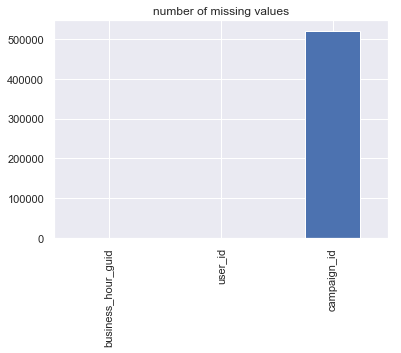

In [56]:
discount.isnull().sum().plot(kind='bar',title='number of missing values') # 檢查空值

In [57]:
discount = discount.drop(columns=['user_id'])

In [58]:
discount = discount.fillna(0) #補空值

In [59]:
def trans(x):
    if x > 0:
        return 1
    else:
        return 0
discount["is_Discount"]=discount["campaign_id"].apply(trans)


In [60]:
##因為有些訂單並沒有使用優惠 discount，故在用guid合併所有欄位 is_Discount欄位顯示總共所有訂單使用優惠次數
discount=discount.groupby('business_hour_guid')['is_Discount'].sum().to_frame()
discount.head(3)

,is_Discount
business_hour_guid,
00000793-A001-4C8C-9196-3E6971181246,0
00001911-C3DF-4143-BC25-8AA5FA1A9AF4,7
00001928-AE75-4AA9-8A47-4BDE96D08C2D,31


In [61]:
# 將其大於0者設為1 即有提供優惠
def trans(x):
    if x > 0:
        return 1
    else:
        return 0
discount["is_Discount"]=discount["is_Discount"].apply(trans)
discount.head()

,is_Discount
business_hour_guid,
00000793-A001-4C8C-9196-3E6971181246,0
00001911-C3DF-4143-BC25-8AA5FA1A9AF4,1
00001928-AE75-4AA9-8A47-4BDE96D08C2D,1
00004599-A7B5-404C-AC84-8AA030B18D3E,1
0000E985-1260-4A96-8A1B-9E899FB0E340,1


In [62]:
discount=discount.reset_index()

In [63]:
byCategory=pd.merge(temp,discount,how='left')

In [64]:
byCategory = byCategory.rename(columns={'longTern': 'is_Longtern','presales':'is_Presales'}) #修改欄位名稱


In [65]:
byCategory.head(3)

,GUID,seller_GUID,seller_name,subtotal_guid,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,code_second,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,is_Presales,product_launch_year,list,unit_price,is_Longtern,category_unit_price,compare_cate_unit_price,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price,len_list,is_Discount
0,45B303F5-2997-4A1E-9CED-D510CFF5B0F0,E4D88D44-A734-4A6B-9174-A862244D2D22,三協成事業有限公司,699.0,0,2015-01-01 12:12:44.947,732103DD-F831-4210-8449-6B1917AA37F5,1,1111761039,0,NaN,2015-01-01 12:00:00.000,2015-01-22 12:00:00.000,2015-01-01 00:00:00.000,2015-01-27 00:00:00.000,Max Tea/印尼/拉茶,249,新北市,八里區,Max Tea-Tarikk印尼拉茶90包方案,1350.0,699.0,20,宅配：只要699元(含運)即可購得【Max Tea】原價1350元Tarikk印尼拉茶90包...,世界公認好喝的奶茶之一！雅加達、峇里島必買伴手禮|口感溫順|好喝就像現泡|還有不可思議的奶泡喔！,NaN,0,1,90.0,[477|492],7,宅配,50,0,0,0,0,0,0.0,0,1112762571,1.112763e+09,43.0,43,30057.0,[],0.0,0,NaN,0,NaN,沖泡/飲品,413.0,50,1,12,3,21,-1,0,2015,['732103DD-F831-4210-8449-6B1917AA37F5'],7.766667,0,145.0,0.054,90.0,699.0,90.0,7.766667,1,1
1,F121067A-41C7-4894-BD82-33A54E589DB7,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,594.0,0,2015-01-01 12:36:05.753,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1,1112303774,0,NaN,2015-01-01 12:00:00.000,2015-01-14 12:00:00.000,2015-01-01 00:00:00.000,2015-01-23 00:00:00.000,暖暖包袋/生理褲,231,新北市,新店區,蕾絲親膚暖暖包袋生理褲（6件方案）,1794.0,594.0,20,宅配：只要594元(含運)即可帶走原價1794元蕾絲親膚暖暖包袋生理褲6件：神秘黑/自然膚/...,每個女人都要有|獨家設計可放暖暖包生理褲！前後三層防漏超透氣|肚子暖暖減少不適感|安心溫暖月月順。,NaN,1,6,6.0,[477],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,17.0,17,10098.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,13,-1,0,2015,['E4849B75-FC79-4B2E-AF00-DF82E59B2872'],99.000000,0,359.0,0.276,6.0,594.0,6.0,99.000000,1,1
2,7CC0DB1C-786E-427E-AD29-C6EC6C860CCF,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,469.0,1,2015-01-01 12:42:11.777,61B117B3-9E4C-4809-9992-0F89E740E5E9,3,1111750722,0,NaN,2015-01-01 12:00:00.000,2015-01-02 12:00:00.000,2015-01-01 00:00:00.000,2015-01-13 00:00:00.000,外套,231,新北市,新店區,連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款,1800.0,469.0,20,宅配：只要469元(含運)即可帶回原價1800元連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款1...,男女款必備雙面配色外套|防水防風面料|舒適透氣易排汗|修飾身材、鬆緊下擺更合身|給您最時尚S...,NaN,1,1,1.0,[477],7,宅配,22,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,216.0,216,101304.0,[],0.0,0,NaN,0,NaN,流行女裝,1604.0,22,1,12,3,1,-1,0,2015,61B117B3-9E4C-4809-9992-0F89E740E5E9,469.000000,0,319.0,1.470,1.0,469.0,1.0,469.000000,36,1


### 計算開賣前三天之銷量

In [66]:
tmp = pd.to_datetime(df['create_time'])-pd.to_datetime(df['business_hour_order_time_s']) #

In [67]:
df['days_diff'] = 0 
df['days_diff'] = [a.days for a in tmp]  
df.head(3)

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,code_second,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,presales,product_launch_year,list,unit_price,longTern,category_unit_price,compare_cate_unit_price,days_diff
0,45B303F5-2997-4A1E-9CED-D510CFF5B0F0,E4D88D44-A734-4A6B-9174-A862244D2D22,三協成事業有限公司,699.0,0,2015-01-01 12:12:44.947,732103DD-F831-4210-8449-6B1917AA37F5,1,1111761039,0,NaN,2015-01-01 12:00:00,2015-01-22 12:00:00,2015-01-01,2015-01-27,Max Tea/印尼/拉茶,249,新北市,八里區,Max Tea-Tarikk印尼拉茶90包方案,1350.0,699.0,20,宅配：只要699元(含運)即可購得【Max Tea】原價1350元Tarikk印尼拉茶90包...,世界公認好喝的奶茶之一！雅加達、峇里島必買伴手禮|口感溫順|好喝就像現泡|還有不可思議的奶泡喔！,NaN,0,1,90.0,[477|492],7,宅配,50,0,0,0,0,0,0.0,0,1112762571,1.112763e+09,43.0,43,30057.0,[],0.0,0,NaN,0,NaN,沖泡/飲品,413.0,50,1,12,3,21,-1,0,2015,[732103DD-F831-4210-8449-6B1917AA37F5],7.766667,0,145.0,0.054,0
1,F121067A-41C7-4894-BD82-33A54E589DB7,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,594.0,0,2015-01-01 12:36:05.753,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1,1112303774,0,NaN,2015-01-01 12:00:00,2015-01-14 12:00:00,2015-01-01,2015-01-23,暖暖包袋/生理褲,231,新北市,新店區,蕾絲親膚暖暖包袋生理褲（6件方案）,1794.0,594.0,20,宅配：只要594元(含運)即可帶走原價1794元蕾絲親膚暖暖包袋生理褲6件：神秘黑/自然膚/...,每個女人都要有|獨家設計可放暖暖包生理褲！前後三層防漏超透氣|肚子暖暖減少不適感|安心溫暖月月順。,NaN,1,6,6.0,[477],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,17.0,17,10098.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,13,-1,0,2015,[E4849B75-FC79-4B2E-AF00-DF82E59B2872],99.000000,0,359.0,0.276,0
2,7CC0DB1C-786E-427E-AD29-C6EC6C860CCF,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,469.0,1,2015-01-01 12:42:11.777,61B117B3-9E4C-4809-9992-0F89E740E5E9,3,1111750722,0,NaN,2015-01-01 12:00:00,2015-01-02 12:00:00,2015-01-01,2015-01-13,外套,231,新北市,新店區,連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款,1800.0,469.0,20,宅配：只要469元(含運)即可帶回原價1800元連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款1...,男女款必備雙面配色外套|防水防風面料|舒適透氣易排汗|修飾身材、鬆緊下擺更合身|給您最時尚S...,NaN,1,1,1.0,[477],7,宅配,22,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,216.0,216,101304.0,[],0.0,0,NaN,0,NaN,流行女裝,1604.0,22,1,12,3,1,-1,0,2015,61B117B3-9E4C-4809-9992-0F89E740E5E9,469.000000,0,319.0,1.470,0


In [68]:
df['sales']=df['subtotal']/df['unit_price']

### 計算商品前3天的銷量、銷量占比

In [69]:
total_sales= df.groupby('business_hour_guid')['sales'].sum().to_frame() #總銷售量依檔次分組
total_sales= total_sales.rename(columns={'sales':'total_sales'}) #更改欄位名稱
total_sales.head(3)

,total_sales
business_hour_guid,
00000793-A001-4C8C-9196-3E6971181246,1.0
00001911-C3DF-4143-BC25-8AA5FA1A9AF4,1.0
00001928-AE75-4AA9-8A47-4BDE96D08C2D,8.0


In [70]:
list = [3]
sales_3days=pd.DataFrame()
for i in list:
    if(i==3):
        output_days=df[df.days_diff<i]  
        text=("sales_"+str(i)+"days")
        text2=("ratio_"+str(i)+"days")
        final_output = output_days.groupby('business_hour_guid')['sales'].sum().to_frame()  #i天數內之銷售量
        final_output = final_output.rename(columns={'sales':text})  #更改欄位名稱
        total = pd.merge(total_sales,final_output ,how='left',on=['business_hour_guid'])
        total = total.fillna(0)   #補空值
        total[text2] = (total[text]/total['total_sales']).round(3) #銷量占比
        sales_3days = total.reset_index() 
    else:
        output_days=df[df.days_diff<i]  
        text=("sales_"+str(i)+"days")
        text2=("ratio_"+str(i)+"days")
        final_output = output_days.groupby('business_hour_guid')['sales'].sum().to_frame()  
        final_output = final_output.rename(columns={'sales':text})  
        final_output=final_output.reset_index() 
        total = pd.merge(total_sales,final_output ,how='left',on=['business_hour_guid'])
        total = total.fillna(0)   
        total[text2] = (total[text]/total['total_sales']).round(3) 
        sales_3days=pd.merge(sales_3days,total,how='left')
sales_3days.head(5)

,business_hour_guid,total_sales,sales_3days,ratio_3days
0,00000793-A001-4C8C-9196-3E6971181246,1.0,1.0,1.000
1,00001911-C3DF-4143-BC25-8AA5FA1A9AF4,1.0,0.0,0.000
2,00001928-AE75-4AA9-8A47-4BDE96D08C2D,8.0,0.0,0.000
3,00004599-A7B5-404C-AC84-8AA030B18D3E,30.0,10.0,0.333
4,0000E985-1260-4A96-8A1B-9E899FB0E340,2.0,0.0,0.000


In [71]:
byCategory=pd.merge(byCategory,sales_3days,how='left')
byCategory.head(3)

,GUID,seller_GUID,seller_name,subtotal_guid,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,code_second,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,is_Presales,product_launch_year,list,unit_price,is_Longtern,category_unit_price,compare_cate_unit_price,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price,len_list,is_Discount,total_sales,sales_3days,ratio_3days
0,45B303F5-2997-4A1E-9CED-D510CFF5B0F0,E4D88D44-A734-4A6B-9174-A862244D2D22,三協成事業有限公司,699.0,0,2015-01-01 12:12:44.947,732103DD-F831-4210-8449-6B1917AA37F5,1,1111761039,0,NaN,2015-01-01 12:00:00.000,2015-01-22 12:00:00.000,2015-01-01 00:00:00.000,2015-01-27 00:00:00.000,Max Tea/印尼/拉茶,249,新北市,八里區,Max Tea-Tarikk印尼拉茶90包方案,1350.0,699.0,20,宅配：只要699元(含運)即可購得【Max Tea】原價1350元Tarikk印尼拉茶90包...,世界公認好喝的奶茶之一！雅加達、峇里島必買伴手禮|口感溫順|好喝就像現泡|還有不可思議的奶泡喔！,NaN,0,1,90.0,[477|492],7,宅配,50,0,0,0,0,0,0.0,0,1112762571,1.112763e+09,43.0,43,30057.0,[],0.0,0,NaN,0,NaN,沖泡/飲品,413.0,50,1,12,3,21,-1,0,2015,['732103DD-F831-4210-8449-6B1917AA37F5'],7.766667,0,145.0,0.054,90.0,699.0,90.0,7.766667,1,1,3870.0,720.0,0.186
1,F121067A-41C7-4894-BD82-33A54E589DB7,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,594.0,0,2015-01-01 12:36:05.753,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1,1112303774,0,NaN,2015-01-01 12:00:00.000,2015-01-14 12:00:00.000,2015-01-01 00:00:00.000,2015-01-23 00:00:00.000,暖暖包袋/生理褲,231,新北市,新店區,蕾絲親膚暖暖包袋生理褲（6件方案）,1794.0,594.0,20,宅配：只要594元(含運)即可帶走原價1794元蕾絲親膚暖暖包袋生理褲6件：神秘黑/自然膚/...,每個女人都要有|獨家設計可放暖暖包生理褲！前後三層防漏超透氣|肚子暖暖減少不適感|安心溫暖月月順。,NaN,1,6,6.0,[477],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,17.0,17,10098.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,13,-1,0,2015,['E4849B75-FC79-4B2E-AF00-DF82E59B2872'],99.000000,0,359.0,0.276,6.0,594.0,6.0,99.000000,1,1,102.0,54.0,0.529
2,7CC0DB1C-786E-427E-AD29-C6EC6C860CCF,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,469.0,1,2015-01-01 12:42:11.777,61B117B3-9E4C-4809-9992-0F89E740E5E9,3,1111750722,0,NaN,2015-01-01 12:00:00.000,2015-01-02 12:00:00.000,2015-01-01 00:00:00.000,2015-01-13 00:00:00.000,外套,231,新北市,新店區,連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款,1800.0,469.0,20,宅配：只要469元(含運)即可帶回原價1800元連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款1...,男女款必備雙面配色外套|防水防風面料|舒適透氣易排汗|修飾身材、鬆緊下擺更合身|給您最時尚S...,NaN,1,1,1.0,[477],7,宅配,22,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,216.0,216,101304.0,[],0.0,0,NaN,0,NaN,流行女裝,1604.0,22,1,12,3,1,-1,0,2015,61B117B3-9E4C-4809-9992-0F89E740E5E9,469.000000,0,319.0,1.470,1.0,469.0,1.0,469.000000,36,1,216.0,216.0,1.000


## 計算標題是否含有熱銷檔次

In [73]:
import numpy as np
import pandas as pd
import jieba
from jieba import analyse
import jieba.analyse

In [74]:
name_str =byCategory['item_name'].astype(str)
name_str.head(3)

0    Max Tea-Tarikk印尼拉茶90包方案
1          蕾絲親膚暖暖包袋生理褲（6件方案）
2      連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款
Name: item_name, dtype: object

In [75]:
total_str =''.join(name_str)
keywords = jieba.analyse.extract_tags(total_str, topK = 100)
keywords

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\Student\AppData\Local\Temp\jieba.cache
Loading model cost 0.745 seconds.
Prefix dict has been built succesfully.


['方案',
 '10',
 '任選',
 '12',
 '系列',
 '20',
 '韓國',
 '多功能',
 '禮盒',
 '雙人',
 '日本',
 '頂級',
 '24',
 '透氣',
 '經典',
 '30',
 'USB',
 '保暖',
 '100%',
 '兩用',
 '16',
 '防水',
 'LED',
 '3D',
 '買新鮮',
 '手機',
 '時尚',
 '運動',
 '內衣',
 '15',
 '包組',
 '加厚',
 '防滑',
 '手工',
 '美國',
 '兒童',
 '隨身',
 '40',
 'MIT',
 '3M',
 '四件',
 '加大',
 '外套',
 '日式',
 '60',
 '專用',
 '棉麻',
 '50',
 '無痕',
 '台灣',
 '保潔',
 '舒適',
 '韓版',
 '天然',
 '立體',
 '一送',
 '行動',
 '18',
 '單人',
 '上衣',
 '休閒',
 '歌林',
 '100',
 '萬用',
 '進口',
 '內褲',
 '電源',
 '迷你',
 '新款',
 '嚴選',
 '無線',
 '360',
 '收納',
 '304',
 '限定',
 '修身',
 'Kolin',
 '蛋糕',
 '自動',
 '彈力',
 'UV',
 '原裝',
 '熱銷',
 '認證',
 '造型',
 '洗衣',
 '福利品',
 '夏日',
 '口罩',
 '伸縮',
 '出貨',
 '真空',
 '新鮮',
 '超大',
 'DIY',
 '背心',
 '蘋果',
 '三件',
 '衣架',
 '飛利浦']

In [76]:
def word(w):
    lst = list(jieba.cut(w,cut_all=False))
    c=0
    for i in lst:
        if i in keywords:
            c+=1
        return(c)

In [77]:
key_lst=[]
key_lst.append(name_str.apply(word))

title=list(byCategory['business_hour_guid'])

A={
    'business_hour_guid':guid,
    'hottimes':key_lst[0]
}
key_lst_df=pd.DataFrame(A)

TypeError: 'list' object is not callable

In [78]:
hotword=pd.read_csv('hotword.csv')
hotword.head()

,Unnamed: 0,business_hour_guid,hottimes
0,0,29B37E53-021C-48E9-909E-C6C151974AC7,0
1,1,2C6E83A9-9785-4593-A759-07A78AB309BB,0
2,2,08EF8DAA-7A9F-4DF4-ADBC-244F285F7C59,0
3,3,7D187D9D-0B7D-4E7A-9F42-38080A58E817,0
4,4,C6729EFD-85FC-4B60-9E40-4B5DDA6695AE,0


In [79]:
byCategory=pd.merge(byCategory,hotword,how="left")

### 計算目標變量

In [80]:
total_subtotal= df.groupby('business_hour_guid')['subtotal'].sum().to_frame() #總銷售金額依檔次分組
total_subtotal= total_subtotal.rename(columns={'subtotal':'total_sales_amount'})

In [81]:
list = [7,14,30,60,180]
sales_amount_ratio=pd.DataFrame()
for i in list:
    if(i==7):
        output_days=df[df.days_diff<i]  
        text=("sales_"+str(i)+"days")
        text2=("ratio_"+str(i)+"days")
        final_output = output_days.groupby('business_hour_guid')['subtotal'].sum().to_frame()  #i天數內之銷售金額
        final_output = final_output.rename(columns={'subtotal':text})  #更改欄位名稱
        total = pd.merge(total_subtotal,final_output ,how='left',on=['business_hour_guid'])
        total = total.fillna(0)   #補空值
        total[text2] = (total[text]/total['total_sales_amount']).round(3) #銷量占比
        sales_amount_ratio = total.reset_index() 
    else:
        output_days=df[df.days_diff<i]  
        text=("sales_"+str(i)+"days")
        text2=("ratio_"+str(i)+"days")
        final_output = output_days.groupby('business_hour_guid')['subtotal'].sum().to_frame()  
        final_output = final_output.rename(columns={'subtotal':text})  
        final_output=final_output.reset_index() 
        total = pd.merge(total_subtotal,final_output ,how='left',on=['business_hour_guid'])
        total = total.fillna(0)   
        total[text2] = (total[text]/total['total_sales_amount']).round(3) 
        sales_amount_ratio=pd.merge(sales_amount_ratio,total,how='left')
sales_amount_ratio.head(3)

,business_hour_guid,total_sales_amount,sales_7days,ratio_7days,sales_14days,ratio_14days,sales_30days,ratio_30days,sales_60days,ratio_60days,sales_180days,ratio_180days
0,00000793-A001-4C8C-9196-3E6971181246,399.0,399.0,1.0,399.0,1.0,399.0,1.0,399.0,1.0,399.0,1.0
1,00001911-C3DF-4143-BC25-8AA5FA1A9AF4,1150.0,1150.0,1.0,1150.0,1.0,1150.0,1.0,1150.0,1.0,1150.0,1.0
2,00001928-AE75-4AA9-8A47-4BDE96D08C2D,23040.0,0.0,0.0,11520.0,0.5,23040.0,1.0,23040.0,1.0,23040.0,1.0


In [82]:
sales_amount_ratio[sales_amount_ratio.business_hour_guid=='FFF83492-B3D9-44CE-9932-E3B6E46D242C']

,business_hour_guid,total_sales_amount,sales_7days,ratio_7days,sales_14days,ratio_14days,sales_30days,ratio_30days,sales_60days,ratio_60days,sales_180days,ratio_180days
223993,FFF83492-B3D9-44CE-9932-E3B6E46D242C,2640.0,880.0,0.333,1760.0,0.667,2640.0,1.0,2640.0,1.0,2640.0,1.0


In [83]:
byCategory=pd.merge(byCategory,sales_amount_ratio,how='left')
byCategory.head(3)

,GUID,seller_GUID,seller_name,subtotal_guid,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,code_second,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,is_Presales,product_launch_year,list,unit_price,is_Longtern,category_unit_price,compare_cate_unit_price,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price,len_list,is_Discount,total_sales,sales_3days,ratio_3days,Unnamed: 0,hottimes,total_sales_amount,sales_7days,ratio_7days,sales_14days,ratio_14days,sales_30days,ratio_30days,sales_60days,ratio_60days,sales_180days,ratio_180days
0,45B303F5-2997-4A1E-9CED-D510CFF5B0F0,E4D88D44-A734-4A6B-9174-A862244D2D22,三協成事業有限公司,699.0,0,2015-01-01 12:12:44.947,732103DD-F831-4210-8449-6B1917AA37F5,1,1111761039,0,NaN,2015-01-01 12:00:00.000,2015-01-22 12:00:00.000,2015-01-01 00:00:00.000,2015-01-27 00:00:00.000,Max Tea/印尼/拉茶,249,新北市,八里區,Max Tea-Tarikk印尼拉茶90包方案,1350.0,699.0,20,宅配：只要699元(含運)即可購得【Max Tea】原價1350元Tarikk印尼拉茶90包...,世界公認好喝的奶茶之一！雅加達、峇里島必買伴手禮|口感溫順|好喝就像現泡|還有不可思議的奶泡喔！,NaN,0,1,90.0,[477|492],7,宅配,50,0,0,0,0,0,0.0,0,1112762571,1.112763e+09,43.0,43,30057.0,[],0.0,0,NaN,0,NaN,沖泡/飲品,413.0,50,1,12,3,21,-1,0,2015,['732103DD-F831-4210-8449-6B1917AA37F5'],7.766667,0,145.0,0.054,90.0,699.0,90.0,7.766667,1,1,3870.0,720.0,0.186,63497,0,30057.0,13281.0,0.442,18174.0,0.605,30057.0,1.0,30057.0,1.0,30057.0,1.0
1,F121067A-41C7-4894-BD82-33A54E589DB7,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,594.0,0,2015-01-01 12:36:05.753,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1,1112303774,0,NaN,2015-01-01 12:00:00.000,2015-01-14 12:00:00.000,2015-01-01 00:00:00.000,2015-01-23 00:00:00.000,暖暖包袋/生理褲,231,新北市,新店區,蕾絲親膚暖暖包袋生理褲（6件方案）,1794.0,594.0,20,宅配：只要594元(含運)即可帶走原價1794元蕾絲親膚暖暖包袋生理褲6件：神秘黑/自然膚/...,每個女人都要有|獨家設計可放暖暖包生理褲！前後三層防漏超透氣|肚子暖暖減少不適感|安心溫暖月月順。,NaN,1,6,6.0,[477],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,17.0,17,10098.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,13,-1,0,2015,['E4849B75-FC79-4B2E-AF00-DF82E59B2872'],99.000000,0,359.0,0.276,6.0,594.0,6.0,99.000000,1,1,102.0,54.0,0.529,63569,0,10098.0,7722.0,0.765,10098.0,1.000,10098.0,1.0,10098.0,1.0,10098.0,1.0
2,7CC0DB1C-786E-427E-AD29-C6EC6C860CCF,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,469.0,1,2015-01-01 12:42:11.777,61B117B3-9E4C-4809-9992-0F89E740E5E9,3,1111750722,0,NaN,2015-01-01 12:00:00.000,2015-01-02 12:00:00.000,2015-01-01 00:00:00.000,2015-01-13 00:00:00.000,外套,231,新北市,新店區,連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款,1800.0,469.0,20,宅配：只要469元(含運)即可帶回原價1800元連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款1...,男女款必備雙面配色外套|防水防風面料|舒適透氣易排汗|修飾身材、鬆緊下擺更合身|給您最時尚S...,NaN,1,1,1.0,[477],7,宅配,22,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,216.0,216,101304.0,[],0.0,0,NaN,0,NaN,流行女裝,1604.0,22,1,12,3,1,-1,0,2015,61B117B3-9E4C-4809-9992-0F89E740E5E9,469.000000,0,319.0,1.470,1.0,469.0,1.0,469.000000,36,1,216.0,216.0,1.000,63433,0,101304.0,101304.0,1.000,101304.0,1.000,101304.0,1.0,101304.0,1.0,101304.0,1.0


In [84]:
byCategory.shippingdate=byCategory.shippingdate.fillna(0)

In [85]:
byCategory[byCategory.business_hour_guid=='FFF83492-B3D9-44CE-9932-E3B6E46D242C']

,GUID,seller_GUID,seller_name,subtotal_guid,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,code_second,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,is_Presales,product_launch_year,list,unit_price,is_Longtern,category_unit_price,compare_cate_unit_price,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price,len_list,is_Discount,total_sales,sales_3days,ratio_3days,Unnamed: 0,hottimes,total_sales_amount,sales_7days,ratio_7days,sales_14days,ratio_14days,sales_30days,ratio_30days,sales_60days,ratio_60days,sales_180days,ratio_180days
25964,F304F597-2031-41D0-864C-FE0023449240,E5776E1C-F5FE-4BAF-A907-753241ED65AB,傑昱設計工程有限公司(ALICE),880.0,0,2015-07-24 20:09:43.723,FFF83492-B3D9-44CE-9932-E3B6E46D242C,1,1112900200,0,NaN,2015-07-22 07:00:00.000,2015-08-13 01:00:00.000,2015-07-22 00:00:00.000,2015-08-14 00:00:00.000,被套/床包/ALICE,220,新北市,板橋區,ALICE-法式美學雙人被套床包四件組（1組方案）,1980.0,880.0,20,只要880元(含運)即可購得原價1980元【ALICE】法式美學雙人被套床包四件組1組|共有...,NaN,NaN,1,1,1.0,[477|492],7,宅配,42,0,1,1,1,0,0.0,0,1112762578,1.112763e+09,3.0,3,2640.0,[],0.0,0,NaN,0,NaN,寢具,4171.0,42,7,7,2,21,-1,0,2015,['FFF83492-B3D9-44CE-9932-E3B6E46D242C'],880.0,0,780.0,1.128,1.0,880.0,1.0,880.0,1,1,3.0,1.0,0.333,104366,0,2640.0,880.0,0.333,1760.0,0.667,2640.0,1.0,2640.0,1.0,2640.0,1.0


In [86]:
byCategory=byCategory.drop_duplicates('business_hour_guid').reset_index(drop=True)

In [87]:
byCategory.head(3)

,GUID,seller_GUID,seller_name,subtotal_guid,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,mobile_pay_type,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,code_second,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,is_Presales,product_launch_year,list,unit_price,is_Longtern,category_unit_price,compare_cate_unit_price,quantity_sold_guid,subtotal_allguid,quantity_sold_allguid,avg_unit_price,len_list,is_Discount,total_sales,sales_3days,ratio_3days,Unnamed: 0,hottimes,total_sales_amount,sales_7days,ratio_7days,sales_14days,ratio_14days,sales_30days,ratio_30days,sales_60days,ratio_60days,sales_180days,ratio_180days
0,45B303F5-2997-4A1E-9CED-D510CFF5B0F0,E4D88D44-A734-4A6B-9174-A862244D2D22,三協成事業有限公司,699.0,0,2015-01-01 12:12:44.947,732103DD-F831-4210-8449-6B1917AA37F5,1,1111761039,0,NaN,2015-01-01 12:00:00.000,2015-01-22 12:00:00.000,2015-01-01 00:00:00.000,2015-01-27 00:00:00.000,Max Tea/印尼/拉茶,249,新北市,八里區,Max Tea-Tarikk印尼拉茶90包方案,1350.0,699.0,20,宅配：只要699元(含運)即可購得【Max Tea】原價1350元Tarikk印尼拉茶90包...,世界公認好喝的奶茶之一！雅加達、峇里島必買伴手禮|口感溫順|好喝就像現泡|還有不可思議的奶泡喔！,NaN,0,1,90.0,[477|492],7,宅配,50,0,0,0,0,0,0.0,0,1112762571,1.112763e+09,43.0,43,30057.0,[],0.0,0,NaN,0,NaN,沖泡/飲品,413.0,50,1,12,3,21,-1,0,2015,['732103DD-F831-4210-8449-6B1917AA37F5'],7.766667,0,145.0,0.054,90.0,699.0,90.0,7.766667,1,1,3870.0,720.0,0.186,63497,0,30057.0,13281.0,0.442,18174.0,0.605,30057.0,1.0,30057.0,1.0,30057.0,1.0
1,F121067A-41C7-4894-BD82-33A54E589DB7,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,594.0,0,2015-01-01 12:36:05.753,E4849B75-FC79-4B2E-AF00-DF82E59B2872,1,1112303774,0,NaN,2015-01-01 12:00:00.000,2015-01-14 12:00:00.000,2015-01-01 00:00:00.000,2015-01-23 00:00:00.000,暖暖包袋/生理褲,231,新北市,新店區,蕾絲親膚暖暖包袋生理褲（6件方案）,1794.0,594.0,20,宅配：只要594元(含運)即可帶走原價1794元蕾絲親膚暖暖包袋生理褲6件：神秘黑/自然膚/...,每個女人都要有|獨家設計可放暖暖包生理褲！前後三層防漏超透氣|肚子暖暖減少不適感|安心溫暖月月順。,NaN,1,6,6.0,[477],7,宅配,39,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,17.0,17,10098.0,[],0.0,0,NaN,0,NaN,居家服/內睡衣著,166.0,39,1,12,3,13,-1,0,2015,['E4849B75-FC79-4B2E-AF00-DF82E59B2872'],99.000000,0,359.0,0.276,6.0,594.0,6.0,99.000000,1,1,102.0,54.0,0.529,63569,0,10098.0,7722.0,0.765,10098.0,1.000,10098.0,1.0,10098.0,1.0,10098.0,1.0
2,7CC0DB1C-786E-427E-AD29-C6EC6C860CCF,23F66516-1395-4FE5-825F-795C9D94DFAA,得力網通有限公司,469.0,1,2015-01-01 12:42:11.777,61B117B3-9E4C-4809-9992-0F89E740E5E9,3,1111750722,0,NaN,2015-01-01 12:00:00.000,2015-01-02 12:00:00.000,2015-01-01 00:00:00.000,2015-01-13 00:00:00.000,外套,231,新北市,新店區,連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款,1800.0,469.0,20,宅配：只要469元(含運)即可帶回原價1800元連帽絲光棉雙面配色防潑水鋪棉保暖外套男女款1...,男女款必備雙面配色外套|防水防風面料|舒適透氣易排汗|修飾身材、鬆緊下擺更合身|給您最時尚S...,NaN,1,1,1.0,[477],7,宅配,22,0,0,0,0,0,0.0,0,1112546348,1.112546e+09,216.0,216,101304.0,[],0.0,0,NaN,0,NaN,流行女裝,1604.0,22,1,12,3,1,-1,0,2015,61B117B3-9E4C-4809-9992-0F89E740E5E9,469.000000,0,319.0,1.470,1.0,469.0,1.0,469.000000,36,1,216.0,216.0,1.000,63433,0,101304.0,101304.0,1.000,101304.0,1.000,101304.0,1.0,101304.0,1.0,101304.0,1.0


In [88]:
byCategory.to_csv('byCategory.csv',index=False)